In [122]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## CNN on `data_v3`

**Goal**: Reach a log-loss of ~1.4

In [123]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import gc

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-beta1


## Load train and test sets

In [145]:
from src.utils import read_shapefile
from config import raw_data_dir

train_shp_df = read_shapefile('train')
test_shp_df = read_shapefile('test')

class_names = pd.read_csv(os.path.join(raw_data_dir, 'crop_id_list.csv'))
class_names = class_names.set_index('crop_id')

train_shp_df['class_name'] = train_shp_df.Crop_Id_Ne.astype(int).replace(class_names.crop.to_dict())
train_shp_df['y'] = train_shp_df.Crop_Id_Ne.astype(int) - 1
train_labels = np.array(train_shp_df['y'])

print(train_shp_df.shape)
train_shp_df.head()

(2494, 6)


,Area,Subregion,Crop_Id_Ne,geometry,class_name,y
Field_Id,,,,,,
1,0.915905,3,8,"POLYGON ((613924.3324000851 6793991.295069702,...",Vineyard,7
2,2.064410,3,6,"POLYGON ((614404.0717397591 6794020.579634549,...",Pecan,5
3,1.080300,3,8,"POLYGON ((614320.2146632321 6793964.242091182,...",Vineyard,7
4,1.316190,3,8,"POLYGON ((614560.5326844405 6794002.249461887,...",Vineyard,7
7,5.529220,3,8,"POLYGON ((614596.6564746551 6794269.865436315,...",Vineyard,7


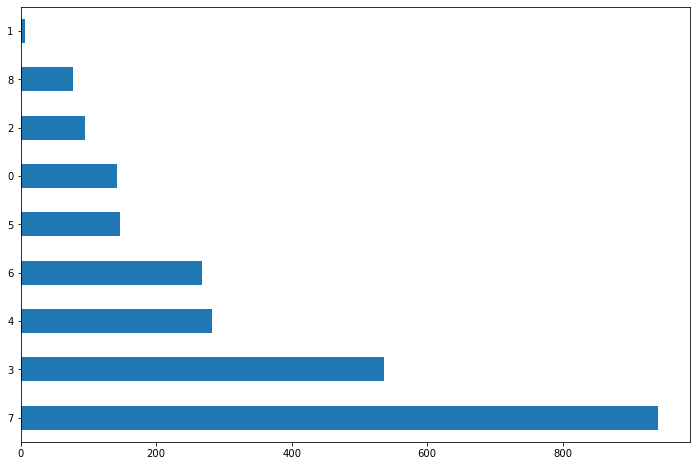

In [147]:
train_shp_df.y.value_counts().plot.barh(figsize=(12,8))

## Read satellite data for one dump, and one spectral band

In [148]:
import os
import cv2

from pathlib import Path
from glob import glob
from config import processed_data_dir

processed_data_dir = Path(processed_data_dir)

train_dir = processed_data_dir /'data_v3' / 'train'
test_dir = processed_data_dir / 'data_v3' / 'test'

train_shp_df['fpath'] = train_shp_df.apply(lambda row: train_dir / str(row.Crop_Id_Ne) / f'{row.name}.npy', axis=1)
test_shp_df['fpath'] = test_shp_df.apply(lambda row: test_dir / f'{row.name}.npy', axis=1)

train_shp_df.head()

,Area,Subregion,Crop_Id_Ne,geometry,class_name,y,fpath
Field_Id,,,,,,,
1,0.915905,3,8,"POLYGON ((613924.3324000851 6793991.295069702,...",Vineyard,7,/Users/renier.botha/dev/personal/ds/zindi/farm...
2,2.064410,3,6,"POLYGON ((614404.0717397591 6794020.579634549,...",Pecan,5,/Users/renier.botha/dev/personal/ds/zindi/farm...
3,1.080300,3,8,"POLYGON ((614320.2146632321 6793964.242091182,...",Vineyard,7,/Users/renier.botha/dev/personal/ds/zindi/farm...
4,1.316190,3,8,"POLYGON ((614560.5326844405 6794002.249461887,...",Vineyard,7,/Users/renier.botha/dev/personal/ds/zindi/farm...
7,5.529220,3,8,"POLYGON ((614596.6564746551 6794269.865436315,...",Vineyard,7,/Users/renier.botha/dev/personal/ds/zindi/farm...


In [149]:
# Load images
train_images_set = {id: np.load(fp) for id, fp in train_shp_df['fpath'].iteritems()}
test_images_set =  {id: np.load(fp) for id, fp in test_shp_df['fpath'].iteritems()}

train_ids = list(map(int,train_images_set.keys()))
test_ids = list(map(int,test_images_set.keys()))

print('First 5 train ids:',train_ids[:5])

First 5 train ids: [1, 2, 3, 4, 7]


In [150]:
MAX_DIMS = (30, 30)

### Convert images set to data array

`train_images_set` is a dictionary in the format {id: data}.

What we want is a `train_data` array in the format `(n_farms, width, height, n_channels)`

In [154]:
# train_data = np.array(list(train_images_set.values()))
# train_data = np.moveaxis(train_data, 1, 3)

# test_data = np.array(list(test_images_set.values()))[:,-1,:,:]
# test_data = np.moveaxis(test_data, 1, 3)

# print('Train data:\t\t', train_data.shape)
# print('Test data:\t\t',test_data.shape)

In [155]:
# 1-D version

train_data = np.array(list(train_images_set.values()))[:,-1,:,:]
train_data = train_data[:, :, :, np.newaxis]

test_data = np.array(list(test_images_set.values()))[:,-1,:,:]
test_data = test_data[:, :, :, np.newaxis]

print('Train data:\t\t', train_data.shape)
print('Test data:\t\t',test_data.shape)

Train data:		 (2494, 30, 30, 1)
Test data:		 (1074, 30, 30, 1)


### Compare data in `train_images_set` and  `train_data` 

This is to make sure that the same image is present in both arrays at the same index

Data at index 0 in train_images_set:



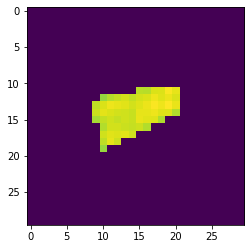

Image in train_data at index 0


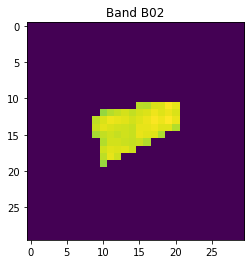

In [156]:
# Pick a farm id in the training set
farm_id = 1

# Get the array from the set
test_arr_1 = train_images_set[farm_id]
test_arr_idx = train_ids.index(int(farm_id))

print('Data at index {} in train_images_set:'.format(test_arr_idx))
print()

# Plot the image
fig, ax = plt.subplots(1, 1)
ax.imshow(test_arr_1[-1])
plt.show()


print('Image in train_data at index {}'.format(test_arr_idx))
# Get the image from the train data array
test_arr_2 = train_data[test_arr_idx]

fig, ax = plt.subplots(1, 1)
ax.imshow(test_arr_2[:, :, 0])
ax.set_title('Band B02')

plt.show()

In [133]:
# # Pick a farm id in the training set
# farm_id = 1

# # Get the array from the set
# test_arr_1 = train_images_set[farm_id]
# test_arr_idx = train_ids.index(int(farm_id))

# print('Data at index {} in train_images_set:'.format(test_arr_idx))
# print()

# # Plot the image
# fig, axes = plt.subplots(1, 3, figsize=(12,8))

# ax = axes[0]
# ax.imshow(test_arr_1[0])
# ax.set_title('Band B02')

# ax = axes[1]
# ax.imshow(test_arr_1[1])
# ax.set_title('Band B03')

# ax = axes[2]
# ax.imshow(test_arr_1[2])
# ax.set_title('Band NDVI')

# plt.show()


# print('Image in train_data at index {}'.format(test_arr_idx))
# # Get the image from the train data array
# test_arr_2 = train_data[test_arr_idx]

# fig, axes = plt.subplots(1, 3, figsize=(12,8))

# ax = axes[0]
# ax.imshow(test_arr_2[:, :, 0])
# ax.set_title('Band B02')

# ax = axes[1]
# ax.imshow(test_arr_2[:, :, 1])
# ax.set_title('Band B03')

# ax = axes[2]
# ax.imshow(test_arr_2[:, :, 2])
# ax.set_title('Band NDVI')

# plt.show()

## Show examples of training data

In [157]:
random_list = np.random.choice(train_ids, size=25)

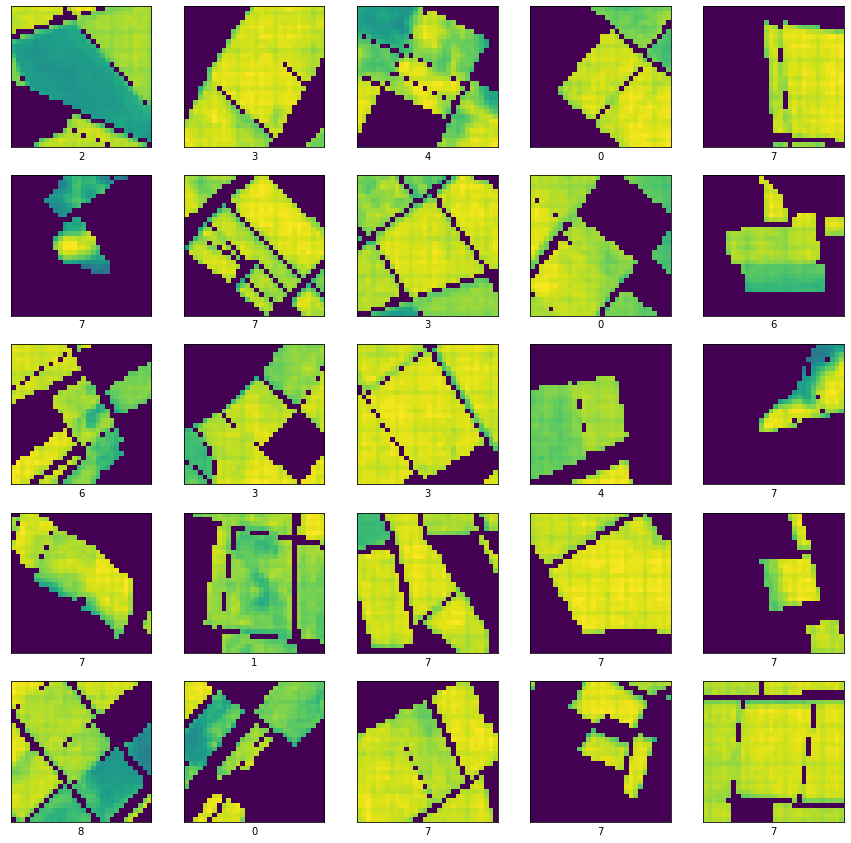

In [158]:
plt.figure(figsize=(15,15))
for i, farm_id in enumerate(random_list):
    
    idx = train_ids.index(farm_id)
    label = train_labels[idx]
    
    img = train_data[idx][:, :, -1]
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.xlabel(label)
    
plt.show()

### Sanity check

Check that after processing the classes and farm IDs match the originals

In [159]:
test = pd.DataFrame({'id': train_ids, 'class': train_labels})

for test_id, test_class in zip(train_ids, train_labels):
    true_class = train_shp_df.loc[test_id].y
    assert test_class == true_class, f'Farm {test_id} has the incorrect class ({test_class} != {true_class})'

print('success')

success


## Build Model 

In [160]:
from sklearn.model_selection import train_test_split

# Split training data into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, stratify=train_labels, random_state=420)

In [161]:
train_labels[:5]

array([4, 2, 7, 6, 4])

In [162]:
val_labels[:5]

array([6, 3, 5, 4, 7])

In [172]:
from tensorflow.keras import models, layers
from src.visualization.tf_viz import PlotLosses

plot_losses = PlotLosses()

def get_model():
    
    model = models.Sequential()
    model.add(layers.Conv2D(8, (4, 4), activation='relu', input_shape=(*MAX_DIMS, 1)))
    model.add(layers.AveragePooling2D((4, 4)))
    model.add(layers.Conv2D(16, (2, 2), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)))
    model.add(layers.Dense(9, activation='softmax'))
    
    return model

In [173]:
class_weights = (1-train_shp_df.y.value_counts(normalize=True)).to_dict()

model = get_model()

adam = keras.optimizers.Adam(learning_rate=0.003)
sgd = keras.optimizers.SGD(learning_rate=0.03, momentum=0.01)

model.compile(optimizer=adam,
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy], )

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 27, 27, 8)         136       
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 16)          528       
_________________________________________________________________
average_pooling2d_2 (Average (None, 2, 2, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 9)                

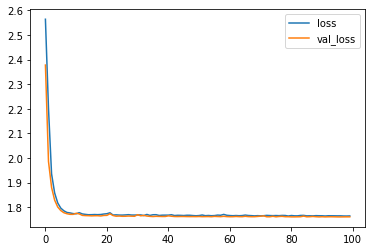

1995/1995 - 0s - loss: 1.7642 - sparse_categorical_crossentropy: 1.7636 - val_loss: 1.7605 - val_sparse_categorical_crossentropy: 1.7602


In [174]:
model.fit(train_data, 
          train_labels,
          batch_size=128,
          validation_data=(val_data, val_labels), 
          verbose=2,
          epochs=100, 
#           class_weight=class_weights,
          callbacks=[plot_losses]
         )

## Current results

Classifier is overfitting :(

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

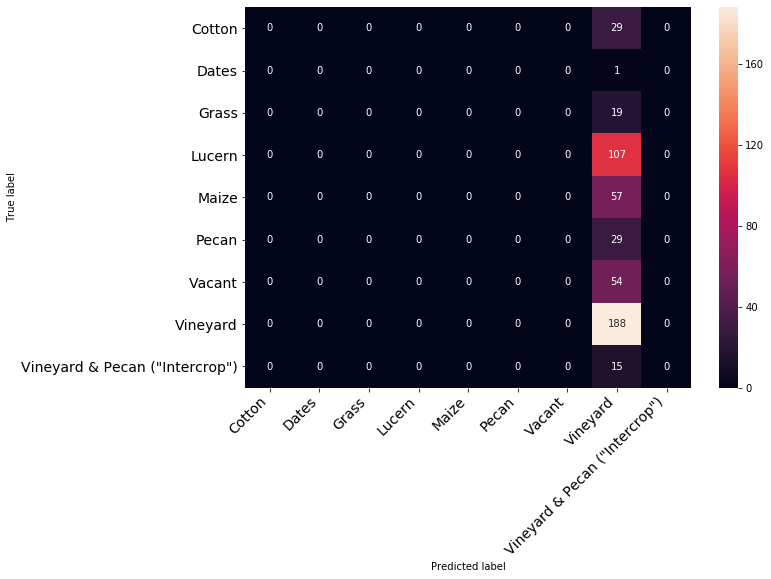

In [168]:
from sklearn.metrics import confusion_matrix

val_preds = model.predict_classes(val_data)

cm = confusion_matrix(y_true=val_labels, y_pred=val_preds, labels=[0,1,2,3,4,5,6,7,8])

print_confusion_matrix(cm, class_names=class_names.crop.to_list() );

### Make submission

In [ ]:
data = np.concatenate((train_data, val_data), axis=0)
labels = np.concatenate((train_labels, val_labels), axis=0)

model = get_model()
model.compile(optimizer=adam,
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.fit(data, 
          labels,
          batch_size=64,
          verbose=2,
          epochs=20, 
          callbacks=[plot_losses])

In [ ]:
predictions = model.predict(test_data)
predictions[:5]

In [ ]:
test_data.shape

In [ ]:
test_shp_df.head()

In [ ]:
def make_sub(predictions):
    
    sub_df = pd.read_csv(os.path.join(raw_data_dir, 'sample_submission_fixed.csv'))

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[test_ids] = predictions
    
    return new_sub


sub_df = make_sub(predictions)

sub_df.head(10)

In [ ]:
from config import subs_dir

sub_df.to_csv(os.path.join(subs_dir,'keras_basic_band_{}_{}.csv'.format(band, date)))

**Submission score:** 1.812

At least this is sort of close to the train score...